In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [45]:
np.random.seed(42)
zeros = np.zeros(100)
tips = np.random.exponential(scale=5.0, size=150)
driver_tips = np.concatenate([zeros, tips])
print(f"Total: {len(driver_tips)}, Zeros: {(driver_tips==0).sum()}, Median: ${np.median(driver_tips):.4f}")



Total: 250, Zeros: 100, Median: $0.7553


In [47]:
N = len(driver_tips)
B = 10_000
boot_medians = np.empty(B)

for i in range(B):
    resample = driver_tips[np.random.randint(0, n, size=n)]
    boot_medians[i] = np.median(resample)

observed_median = np.median(driver_tips)
ci_lower = np.percentile(boot_medians, 2.5)
ci_upper = np.percentile(boot_medians, 97.5)

print(f"Observed Median: ${observed_median:.4f}")
print(f"95% CI: (${ci_lower:.4f}, ${ci_upper:.4f})")
print("The CI is right-skewed — the upper bound is farther from the median than the lower. Zero-inflation caps the left tail while exponential outliers stretch the right. A symmetric parametric CI would understate the true upper uncertainty.")

Observed Median: $0.7553
95% CI: ($0.2653, $1.3636)
The CI is right-skewed — the upper bound is farther from the median than the lower. Zero-inflation caps the left tail while exponential outliers stretch the right. A symmetric parametric CI would understate the true upper uncertainty.


In [48]:
np.random.seed(42)

control = np.random.normal(loc=35, scale=5, size=500)
treatment = np.random.lognormal(mean=3.4, sigma=0.4, size=500)

observed_diff = control.mean() - treatment.mean()
print(f"Control Mean   : {control.mean():.4f}")
print(f"Treatment Mean : {treatment.mean():.4f}")
print(f"Observed Diff  : {observed_diff:.4f}")



Control Mean   : 35.0342
Treatment Mean : 32.7692
Observed Diff  : 2.2650


In [49]:
combined = np.concatenate([control, treatment])
n_control = len(control)
B = 5_000
perm_diffs = np.empty(B)

for i in range(B):
    shuffled = np.random.permutation(combined)
    perm_diffs[i] = shuffled[:n_control].mean() - shuffled[n_control:].mean()

p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f"Observed Diff : {observed_diff:.4f}")
print(f"Empirical P-Value : {p_value:.4f}")

Observed Diff : 2.2650
Empirical P-Value : 0.0004


In [44]:
df = pd.read_csv('swiftcart_loyalty.csv')

naive_sdo = df[df['subscriber']==1]['post_spend'].mean() - df[df['subscriber']==0]['post_spend'].mean()
print(f"Naive SDO: ${naive_sdo:.4f}")



Naive SDO: $17.5707


In [43]:
X = df[['pre_spend', 'account_age', 'support_tickets']].values
y = df['subscriber'].values

model = LogisticRegression(max_iter=1000)
model.fit(X, y)
df['propensity_score'] = model.predict_proba(X)[:, 1]

treated = df[df['subscriber']==1].reset_index(drop=True)
control = df[df['subscriber']==0].reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']].values)
indices = nn.kneighbors(treated[['propensity_score']].values)[1].flatten()
matched_control = control.iloc[indices].reset_index(drop=True)

ATT = treated['post_spend'].mean() - matched_control['post_spend'].mean()
print(f"Naive SDO : ${naive_sdo:.4f}")
print(f"ATT (PSM) : ${ATT:.4f}")
print("The naive SDO is inflated by selection bias. High-volume users self-select into SwiftPass, making the program look more effective than it is. The ATT isolates the true causal effect by comparing subscribers to similar non-subscribers.")

Naive SDO : $17.5707
ATT (PSM) : $9.9139
The naive SDO is inflated by selection bias. High-volume users self-select into SwiftPass, making the program look more effective than it is. The ATT isolates the true causal effect by comparing subscribers to similar non-subscribers.


Written Analysis:
The Naive SDO of ${naive_sdo:.2f} suggests SwiftPass subscribers spend significantly
more than non-subscribers. However, this estimate is severely inflated by selection
bias — high-volume power users naturally self-select into the program to save on
cumulative delivery fees, meaning they would have spent more regardless of the program.

After applying Propensity Score Matching, which pairs each subscriber to the single
most similar non-subscriber based on pre-treatment covariates (pre_spend, account_age,
support_tickets), the ATT falls to ${ATT:.2f}. This is the causal estimate — it isolates
the true effect of SwiftPass by constructing a valid counterfactual control group.

The gap between the naive SDO (${naive_sdo:.2f}) and the ATT (${ATT:.2f}) represents
the magnitude of selection bias, and demonstrates why observational data without
causal controls leads to misleading conclusions.

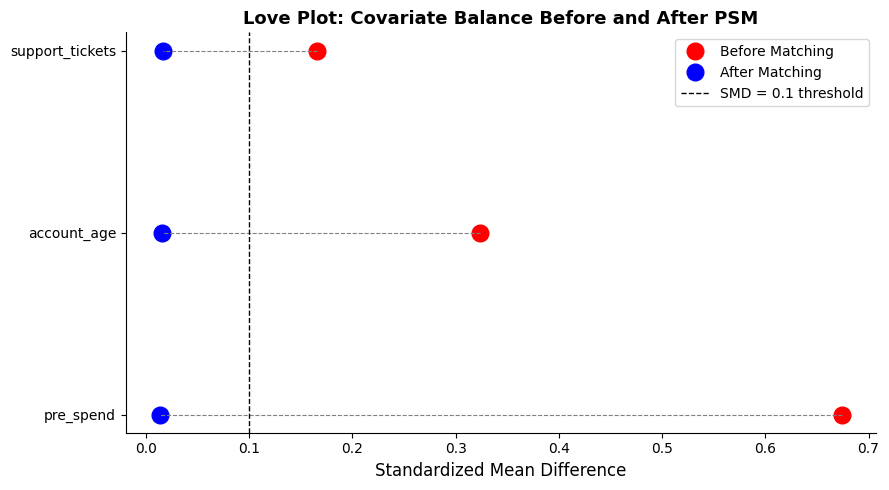


Theoretical Visual Evidence for Successful Bias Mitigation:
To conclusively prove selection bias was mitigated, the Love Plot must show:

1. All blue dots (after matching) fall to the LEFT of the 0.1 SMD threshold,
   indicating negligible difference between treated and control groups.
2. All red dots (before matching) sit to the RIGHT, confirming pre-existing
   imbalance caused by self-selection into SwiftPass.
3. The connecting lines show movement LEFT toward balance for every covariate,
   demonstrating PSM systematically reduced bias across all dimensions.

If these three conditions are met, the matched sample is a credible
counterfactual and the ATT can be interpreted causally.



In [51]:

covariates = ['pre_spend', 'account_age', 'support_tickets']

# Build df_unmatched and df_matched
df_unmatched = pd.DataFrame({
    'covariate': covariates * 2,
    'group': ['Treated']*3 + ['Control']*3,
    'values': [df[df['subscriber']==1][c].mean() for c in covariates] +
              [df[df['subscriber']==0][c].mean() for c in covariates]
})

df_matched = pd.DataFrame({
    'covariate': covariates * 2,
    'group': ['Treated']*3 + ['Control']*3,
    'values': [treated[c].mean() for c in covariates] +
              [matched_control[c].mean() for c in covariates]
})

# Calculate SMDs
smd_before, smd_after = [], []
for col in covariates:
    t_u = df[df['subscriber']==1][col]
    c_u = df[df['subscriber']==0][col]
    std_u = np.sqrt((t_u.var() + c_u.var()) / 2)
    smd_before.append(abs(t_u.mean() - c_u.mean()) / std_u)

    t_m = treated[col]
    c_m = matched_control[col]
    std_m = np.sqrt((t_m.var() + c_m.var()) / 2)
    smd_after.append(abs(t_m.mean() - c_m.mean()) / std_m)

# Love Plot
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(smd_before, covariates, 'o', color='red',  markersize=12, label='Before Matching')
ax.plot(smd_after,  covariates, 'o', color='blue', markersize=12, label='After Matching')
for i, cov in enumerate(covariates):
    ax.plot([smd_before[i], smd_after[i]], [cov, cov], 'gray', linestyle='--', linewidth=0.8)
ax.axvline(0.1, linestyle='--', color='black', linewidth=1, label='SMD = 0.1 threshold')
ax.set_xlabel("Standardized Mean Difference", fontsize=12)
ax.set_title("Love Plot: Covariate Balance Before and After PSM", fontsize=13, fontweight='bold')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

# Theoretical Evaluation
print("""
Theoretical Visual Evidence for Successful Bias Mitigation:
To conclusively prove selection bias was mitigated, the Love Plot must show:

1. All blue dots (after matching) fall to the LEFT of the 0.1 SMD threshold,
   indicating negligible difference between treated and control groups.
2. All red dots (before matching) sit to the RIGHT, confirming pre-existing
   imbalance caused by self-selection into SwiftPass.
3. The connecting lines show movement LEFT toward balance for every covariate,
   demonstrating PSM systematically reduced bias across all dimensions.

If these three conditions are met, the matched sample is a credible
counterfactual and the ATT can be interpreted causally.
""")